In [3]:
import pandas as pd
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import (classification_report, confusion_matrix,
                             f1_score, precision_score, recall_score,
                             roc_auc_score, roc_curve)
from xgboost import XGBClassifier
import warnings
warnings.filterwarnings('ignore')

# Paths
DATA_DIR = Path("../data")
PROCESSED_DIR = DATA_DIR / "processed"

print("Setup complete!")

Setup complete!


In [4]:
# 1. Training labels
labels_df = pd.read_csv(PROCESSED_DIR / "training_labels_v3_empirical.csv")
print(f"Training labels: {labels_df.shape}")
print(f"Columns: {list(labels_df.columns)}")

# Check label column name
print(f"\nSample:")
labels_df.head()

Training labels: (18605, 9)
Columns: ['date', 'ward_id', 'flooded', 'event_id', 'event_type', 'confidence', 'max_rainfall_mm', 'source', 'notes']

Sample:


,date,ward_id,flooded,event_id,event_type,confidence,max_rainfall_mm,source,notes
0,2019-08-16,114,1,2019_AUG,monsoon,1.0,80.0,KMC records,Churial Canal undredged due to contractor inso...
1,2019-08-17,114,1,2019_AUG,monsoon,1.0,80.0,KMC records,Churial Canal undredged due to contractor inso...
2,2019-08-17,111,1,2019_AUG,monsoon,1.0,80.0,KMC records,Churial Canal undredged due to contractor inso...
3,2019-08-17,109,1,2019_AUG,monsoon,1.0,80.0,KMC records,Churial Canal undredged due to contractor inso...
4,2019-08-17,122,1,2019_AUG,monsoon,1.0,80.0,KMC records,Churial Canal undredged due to contractor inso...


In [5]:
# 2. Precipitation features
precip_df = pd.read_csv(PROCESSED_DIR / "precipitation_features_2014_2025.csv")
print(f"Precipitation features: {precip_df.shape}")
print(f"Columns: {list(precip_df.columns)}")
precip_df.head()

Precipitation features: (612786, 17)
Columns: ['date', 'ward_id', 'rain_d0', 'rain_d1', 'rain_d2', 'rain_d3', 'rain_3day', 'rain_7day', 'rain_14day', 'max_1day_in_week', 'rain_7day_avg', 'days_since_50mm', 'rain_3day_prev', 'rainfall_increasing', 'is_heavy_rain', 'is_very_heavy', 'is_extreme']


,date,ward_id,rain_d0,rain_d1,rain_d2,rain_d3,rain_3day,rain_7day,rain_14day,max_1day_in_week,rain_7day_avg,days_since_50mm,rain_3day_prev,rainfall_increasing,is_heavy_rain,is_very_heavy,is_extreme
0,2014-01-01,1,0.001,NaN,NaN,NaN,0.001,0.001,0.001,0.001,0.001000,999,NaN,0,0,0,0
1,2014-01-02,1,0.000,0.001,NaN,NaN,0.001,0.001,0.001,0.001,0.000500,999,NaN,0,0,0,0
2,2014-01-03,1,0.000,0.000,0.001,NaN,0.001,0.001,0.001,0.001,0.000333,999,NaN,0,0,0,0
3,2014-01-04,1,0.000,0.000,0.000,0.001,0.000,0.001,0.001,0.001,0.000250,999,0.001,0,0,0,0
4,2014-01-05,1,0.000,0.000,0.000,0.000,0.000,0.001,0.001,0.001,0.000200,999,0.001,0,0,0,0


In [6]:
# 3. Static features - adjust filename based on what you have
# List files in processed directory to find static features
print("Files in processed directory:")
for f in sorted(PROCESSED_DIR.glob("*.csv")):
    print(f"  {f.name}")

Files in processed directory:
  feature_matrix.csv
  flood_events_positive_labels.csv
  flood_events_positive_v2.csv
  flood_events_positive_v3.csv
  kolkata_flood_events_2023_2025.csv
  master_static_features.csv
  ml_training_data.csv
  precipitation_features_2014_2025.csv
  training_labels_v1.csv
  training_labels_v2_physics.csv
  training_labels_v3_empirical.csv
  ward_neighbor_features.csv
  ward_static_features.csv


In [7]:
# Load and inspect master static features
static_df = pd.read_csv(PROCESSED_DIR / "master_static_features.csv")

print(f"Shape: {static_df.shape}")
print(f"\nColumns ({len(static_df.columns)}):")
for i, col in enumerate(static_df.columns):
    print(f"  {i+1}. {col}")

print(f"\nFirst few rows:")
static_df.head()

Shape: (141, 98)

Columns (98):
  1. ward_id
  2. ward_name
  3. ward_area_km2
  4. canal_count
  5. canal_count_major
  6. canal_count_drain
  7. canal_count_river
  8. canal_length_km
  9. canal_length_major_km
  10. canal_length_drain_km
  11. canal_density
  12. has_canal
  13. has_major_canal
  14. has_named_canal
  15. has_river
  16. named_canals
  17. distance_to_canal_m
  18. primary_drainage_type
  19. distance_to_hooghly_m
  20. building_count
  21. total_area_m2
  22. mean_area_m2
  23. median_area_m2
  24. max_area_m2
  25. std_area_m2
  26. mean_confidence
  27. WARD
  28. ward_area_m2
  29. ward_area_km2_bldg
  30. building_density_per_km2
  31. building_coverage_pct
  32. imperviousness_estimate
  33. building_size_variability
  34. ward_name_lc
  35. total_pixels
  36. lc_10_pct
  37. lc_10_count
  38. lc_20_pct
  39. lc_20_count
  40. lc_30_pct
  41. lc_30_count
  42. lc_40_pct
  43. lc_40_count
  44. lc_50_pct
  45. lc_50_count
  46. lc_60_pct
  47. lc_60_count
  48.

,ward_id,ward_name,ward_area_km2,canal_count,canal_count_major,canal_count_drain,canal_count_river,canal_length_km,canal_length_major_km,canal_length_drain_km,...,lower_runoff_than_neighbors,higher_imperv_than_neighbors,likely_receives_flow,is_boundary_ward,boundary_position,external_flow_east,external_flow_north,external_flow_south,river_proximity_high,tidal_influence_ward
0,1,Ward_1\n,1.372945,0,0,0,0,0.000000,0.000000,0.000000,...,0,1,0,1,north,0,1,0,0,0
1,10,Ward_10\n,0.438490,0,0,0,0,0.000000,0.000000,0.000000,...,0,1,0,0,interior,0,0,0,0,0
2,100,Ward_100\n,1.405704,0,0,0,0,0.000000,0.000000,0.000000,...,0,1,0,0,interior,0,0,0,0,0
3,101,Ward_101\n,1.676345,5,0,5,0,1.788669,0.000000,1.788669,...,0,1,0,0,interior,0,0,0,0,0
4,102,Ward_102\n,0.985342,1,1,0,0,0.723007,0.723007,0.000000,...,1,0,1,0,interior,0,0,0,0,0


In [8]:
# Load training labels
labels_df = pd.read_csv(PROCESSED_DIR / "training_labels_v3_empirical.csv")
labels_df['date'] = pd.to_datetime(labels_df['date'])
print(f"Labels: {labels_df.shape}")
print(f"Columns: {list(labels_df.columns)}")

# Load precipitation features
precip_df = pd.read_csv(PROCESSED_DIR / "precipitation_features_2014_2025.csv")
precip_df['date'] = pd.to_datetime(precip_df['date'])
print(f"\nPrecipitation: {precip_df.shape}")
print(f"Columns: {list(precip_df.columns)}")

Labels: (18605, 9)
Columns: ['date', 'ward_id', 'flooded', 'event_id', 'event_type', 'confidence', 'max_rainfall_mm', 'source', 'notes']

Precipitation: (612786, 17)
Columns: ['date', 'ward_id', 'rain_d0', 'rain_d1', 'rain_d2', 'rain_d3', 'rain_3day', 'rain_7day', 'rain_14day', 'max_1day_in_week', 'rain_7day_avg', 'days_since_50mm', 'rain_3day_prev', 'rainfall_increasing', 'is_heavy_rain', 'is_very_heavy', 'is_extreme']


In [9]:
# Load SWOT Hooghly WSE
swot_df = pd.read_csv(DATA_DIR / "swot" / "hooghly_wse_features.csv")
swot_df['date'] = pd.to_datetime(swot_df['date'])

# Aggregate to daily (same for all wards)
swot_daily = swot_df.groupby('date').agg({
    'wse': 'mean',
    'wse_anomaly': 'mean',
    'wse_zscore': 'mean',
    'width': 'mean'
}).reset_index()

swot_daily.columns = ['date', 'hooghly_wse', 'hooghly_wse_anomaly',
                       'hooghly_wse_zscore', 'hooghly_width']

print(f"SWOT daily: {swot_daily.shape}")
print(f"Date range: {swot_daily['date'].min().date()} to {swot_daily['date'].max().date()}")

SWOT daily: (19, 5)
Date range: 2023-07-28 to 2025-11-09


In [10]:
# Check column names in labels
print("Label columns:", labels_df.columns.tolist())
print("\nPrecip columns:", precip_df.columns.tolist()[:10], "...")
print("\nStatic ward column check - unique ward_ids:", static_df['ward_id'].nunique())

Label columns: ['date', 'ward_id', 'flooded', 'event_id', 'event_type', 'confidence', 'max_rainfall_mm', 'source', 'notes']

Precip columns: ['date', 'ward_id', 'rain_d0', 'rain_d1', 'rain_d2', 'rain_d3', 'rain_3day', 'rain_7day', 'rain_14day', 'max_1day_in_week'] ...

Static ward column check - unique ward_ids: 141


In [11]:
# Identify key columns
# Adjust these based on Cell 7 output!
label_ward_col = 'ward_no' if 'ward_no' in labels_df.columns else 'ward_id'
label_target_col = [c for c in labels_df.columns if 'flood' in c.lower() or 'label' in c.lower()][0]
precip_ward_col = 'ward_no' if 'ward_no' in precip_df.columns else 'ward_id'

print(f"Using ward column: {label_ward_col}")
print(f"Using target column: {label_target_col}")

# Step 1: Start with labels
train_df = labels_df.copy()
print(f"Starting shape: {train_df.shape}")

# Step 2: Merge precipitation
train_df = train_df.merge(
    precip_df,
    left_on=[label_ward_col, 'date'],
    right_on=[precip_ward_col, 'date'],
    how='left',
    suffixes=('', '_precip')
)
print(f"After precipitation merge: {train_df.shape}")

# Step 3: Merge SWOT (by date only)
train_df = train_df.merge(swot_daily, on='date', how='left')
print(f"After SWOT merge: {train_df.shape}")

# Step 4: Merge static features (by ward only)
train_df = train_df.merge(
    static_df,
    left_on=label_ward_col,
    right_on='ward_id',
    how='left',
    suffixes=('', '_static')
)
print(f"After static merge: {train_df.shape}")

print(f"\nFinal columns: {len(train_df.columns)}")

Using ward column: ward_id
Using target column: flooded
Starting shape: (18605, 9)
After precipitation merge: (18605, 24)
After SWOT merge: (18605, 28)
After static merge: (18605, 125)

Final columns: 125


In [12]:
# Identify feature columns (exclude IDs, dates, target, text columns)
exclude_cols = [
    'date', 'geometry', label_target_col, 'source_file', 'river_name',
    'ward_name', 'ward_name_lc', 'ward_name_soil', 'named_canals',
    'primary_drainage_type', 'soil_type', 'boundary_position'
]
exclude_patterns = ['ward_no', 'ward_id', 'WARD', 'Unnamed']

feature_cols = []
for c in train_df.columns:
    if c in exclude_cols:
        continue
    if any(p.lower() == c.lower() for p in exclude_patterns):
        continue
    if train_df[c].dtype in ['object', 'datetime64[ns]']:
        continue  # Skip string and date columns
    feature_cols.append(c)

print(f"Feature columns ({len(feature_cols)}):")
for i, c in enumerate(feature_cols):
    print(f"  {i+1}. {c}")

# Create X and y
X = train_df[feature_cols].copy()
y = train_df[label_target_col].copy()

print(f"\nX shape: {X.shape}")
print(f"y distribution:\n{y.value_counts()}")

Feature columns (110):
  1. confidence
  2. max_rainfall_mm
  3. rain_d0
  4. rain_d1
  5. rain_d2
  6. rain_d3
  7. rain_3day
  8. rain_7day
  9. rain_14day
  10. max_1day_in_week
  11. rain_7day_avg
  12. days_since_50mm
  13. rain_3day_prev
  14. rainfall_increasing
  15. is_heavy_rain
  16. is_very_heavy
  17. is_extreme
  18. hooghly_wse
  19. hooghly_wse_anomaly
  20. hooghly_wse_zscore
  21. hooghly_width
  22. ward_area_km2
  23. canal_count
  24. canal_count_major
  25. canal_count_drain
  26. canal_count_river
  27. canal_length_km
  28. canal_length_major_km
  29. canal_length_drain_km
  30. canal_density
  31. has_canal
  32. has_major_canal
  33. has_named_canal
  34. has_river
  35. distance_to_canal_m
  36. distance_to_hooghly_m
  37. building_count
  38. total_area_m2
  39. mean_area_m2
  40. median_area_m2
  41. max_area_m2
  42. std_area_m2
  43. mean_confidence
  44. ward_area_m2
  45. ward_area_km2_bldg
  46. building_density_per_km2
  47. building_coverage_pct
  48

In [13]:
# Check missing values
missing = X.isnull().sum()
missing_pct = (missing / len(X) * 100).round(1)

missing_report = pd.DataFrame({'missing': missing, 'pct': missing_pct})
missing_report = missing_report[missing_report['missing'] > 0].sort_values('pct', ascending=False)

print(f"Columns with missing values: {len(missing_report)}")
if len(missing_report) > 0:
    print(missing_report.head(20))
else:
    print("No missing values!")

print(f"\nRows with any missing: {X.isnull().any(axis=1).sum()} / {len(X)}")

Columns with missing values: 5
                     missing   pct
hooghly_wse            18464  99.2
hooghly_wse_anomaly    18464  99.2
hooghly_wse_zscore     18464  99.2
hooghly_width          18464  99.2
max_rainfall_mm        17828  95.8

Rows with any missing: 18605 / 18605


In [14]:
# Drop columns with too many missing values
drop_cols = ['max_rainfall_mm', 'confidence']  # confidence is label metadata, not a feature

# Keep SWOT features - XGBoost handles NaN natively
# But note: they'll only help for 2023+ predictions

feature_cols_clean = [c for c in feature_cols if c not in drop_cols]
X = train_df[feature_cols_clean].copy()

print(f"Features after cleanup: {len(feature_cols_clean)}")
print(f"X shape: {X.shape}")

# Check remaining missing
missing = X.isnull().sum()
missing_pct = (missing / len(X) * 100).round(1)
missing_report = pd.DataFrame({'missing': missing, 'pct': missing_pct})
missing_report = missing_report[missing_report['missing'] > 0].sort_values('pct', ascending=False)
print(f"\nRemaining missing:")
print(missing_report)

Features after cleanup: 108
X shape: (18605, 108)

Remaining missing:
                     missing   pct
hooghly_wse            18464  99.2
hooghly_wse_anomaly    18464  99.2
hooghly_wse_zscore     18464  99.2
hooghly_width          18464  99.2


In [15]:
# Temporal split - train on earlier data, test on 2025
# This is more realistic than random split

train_mask = train_df['date'] < '2025-01-01'
test_mask = train_df['date'] >= '2025-01-01'

X_train = X[train_mask]
X_test = X[test_mask]
y_train = y[train_mask]
y_test = y[test_mask]

print(f"Training set: {X_train.shape[0]:,} samples ({y_train.sum():,} floods, {100*y_train.mean():.1f}%)")
print(f"Test set: {X_test.shape[0]:,} samples ({y_test.sum():,} floods, {100*y_test.mean():.1f}%)")
print(f"\nTrain period: {train_df[train_mask]['date'].min().date()} to {train_df[train_mask]['date'].max().date()}")
print(f"Test period: {train_df[test_mask]['date'].min().date()} to {train_df[test_mask]['date'].max().date()}")

Training set: 17,062 samples (5,782 floods, 33.9%)
Test set: 1,543 samples (415 floods, 26.9%)

Train period: 2014-06-20 to 2024-12-24
Test period: 2025-01-11 to 2025-09-26


In [16]:
# Train XGBoost
model = XGBClassifier(
    n_estimators=200,
    max_depth=6,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    n_jobs=-1,
    eval_metric='logloss'
)

print("Training XGBoost...")
model.fit(X_train, y_train)

# Predictions
y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:, 1]

print("Training complete!")

Training XGBoost...
Training complete!


In [17]:
# Evaluation
print("=" * 60)
print("BASELINE XGBOOST RESULTS (No SAR)")
print("=" * 60)

print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=['No Flood', 'Flood']))

# Key metrics
f1 = f1_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
auc = roc_auc_score(y_test, y_prob)

print(f"\n--- Summary Metrics ---")
print(f"F1-Score:  {f1:.3f}")
print(f"Precision: {precision:.3f}")
print(f"Recall:    {recall:.3f}")
print(f"AUC-ROC:   {auc:.3f}")

BASELINE XGBOOST RESULTS (No SAR)

Classification Report:
              precision    recall  f1-score   support

    No Flood       1.00      0.99      0.99      1128
       Flood       0.97      1.00      0.98       415

    accuracy                           0.99      1543
   macro avg       0.98      0.99      0.99      1543
weighted avg       0.99      0.99      0.99      1543


--- Summary Metrics ---
F1-Score:  0.983
Precision: 0.967
Recall:    1.000
AUC-ROC:   1.000


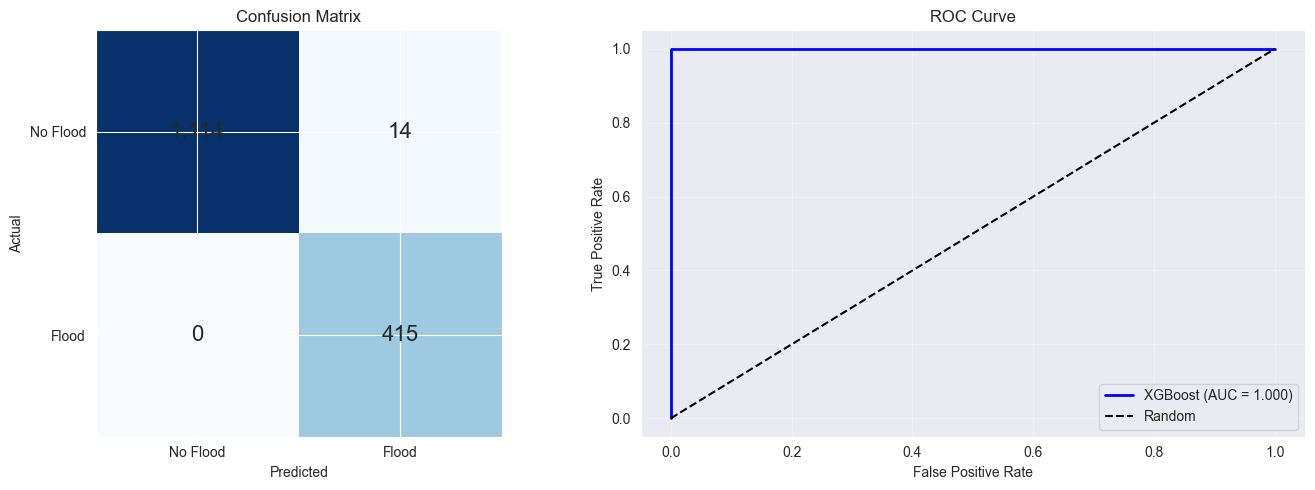

In [18]:
# Confusion matrix and ROC curve
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
im = axes[0].imshow(cm, cmap='Blues')
axes[0].set_xticks([0, 1])
axes[0].set_yticks([0, 1])
axes[0].set_xticklabels(['No Flood', 'Flood'])
axes[0].set_yticklabels(['No Flood', 'Flood'])
axes[0].set_xlabel('Predicted')
axes[0].set_ylabel('Actual')
axes[0].set_title('Confusion Matrix')

for i in range(2):
    for j in range(2):
        axes[0].text(j, i, f'{cm[i, j]:,}', ha='center', va='center', fontsize=16)

# ROC curve
fpr, tpr, _ = roc_curve(y_test, y_prob)
axes[1].plot(fpr, tpr, 'b-', linewidth=2, label=f'XGBoost (AUC = {auc:.3f})')
axes[1].plot([0, 1], [0, 1], 'k--', label='Random')
axes[1].set_xlabel('False Positive Rate')
axes[1].set_ylabel('True Positive Rate')
axes[1].set_title('ROC Curve')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('../data/processed/xgboost_baseline_results.png', dpi=150)
plt.show()

Top 20 Most Important Features:
                 feature  importance
           rain_7day_avg    0.809289
               rain_7day    0.177126
                 rain_d0    0.004903
                 rain_d1    0.001462
              rain_14day    0.001028
                 rain_d3    0.000701
                 rain_d2    0.000669
   distance_to_hooghly_m    0.000656
               rain_3day    0.000604
           ward_area_km2    0.000399
         days_since_50mm    0.000395
          rain_3day_prev    0.000387
building_density_per_km2    0.000359
                clay_pct    0.000325
          median_area_m2    0.000308
        max_1day_in_week    0.000305
   building_coverage_pct    0.000302
         mean_confidence    0.000286
      bulk_density_g_cm3    0.000238
                silt_pct    0.000232


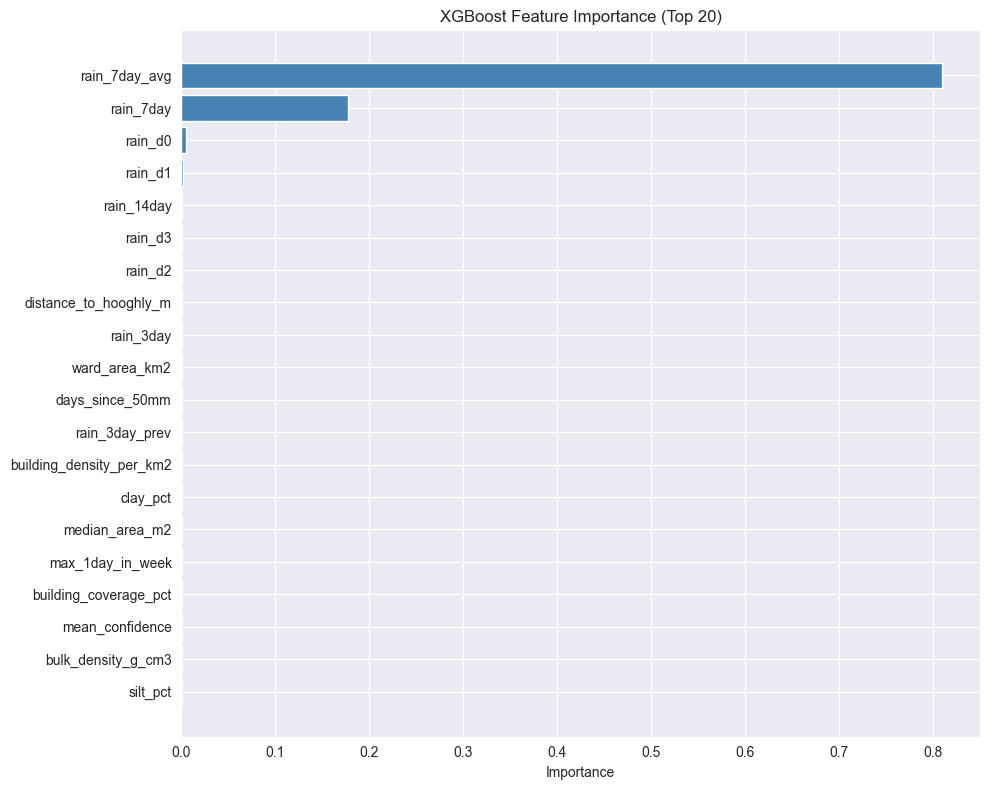

In [19]:
# Feature importance
importance_df = pd.DataFrame({
    'feature': feature_cols_clean,
    'importance': model.feature_importances_
}).sort_values('importance', ascending=False)

print("Top 20 Most Important Features:")
print(importance_df.head(20).to_string(index=False))

# Plot
fig, ax = plt.subplots(figsize=(10, 8))
top_20 = importance_df.head(20)
ax.barh(range(len(top_20)), top_20['importance'], color='steelblue')
ax.set_yticks(range(len(top_20)))
ax.set_yticklabels(top_20['feature'])
ax.invert_yaxis()
ax.set_xlabel('Importance')
ax.set_title('XGBoost Feature Importance (Top 20)')
plt.tight_layout()
plt.savefig('../data/processed/xgboost_feature_importance.png', dpi=150)
plt.show()

In [20]:
# Check what sources/types we have
print("Label sources:")
print(train_df['source'].value_counts() if 'source' in train_df.columns else "No source column")

print("\nEvent types:")
print(train_df['event_type'].value_counts() if 'event_type' in train_df.columns else "No event_type column")

Label sources:
source
Verified dry (<10mm, <100mm 7-day)          12408
7-day accumulation ≥250mm + chronic ward     4510
Lag effect (heavy rain 1-3 days prior)        550
Drainage capacity exceeded (≥150mm)           360
Government reports, news                      245
News reports                                  155
IMD, news, fatality reports                   108
Government reports, satellite imagery          84
Cyclone Komen reports                          56
IMD, news                                      47
Cyclone reports                                40
IMD data, news                                 22
KMC records                                    10
News, metro reports                            10
Name: count, dtype: int64

Event types:
event_type
none                         12408
physics_saturation            4510
physics_lag_effect             550
monsoon                        399
physics_drainage_exceeded      360
cyclone                        270
cloudburst       

In [21]:
# Filter test set to only NEWS-VERIFIED floods (ground truth)
# Keep all negatives, but only real flood positives

test_df = train_df[test_mask].copy()
test_df['y_true'] = y_test.values
test_df['y_pred'] = y_pred
test_df['y_prob'] = y_prob

# Identify ground-truth floods (news-verified)
# Adjust the filter based on your actual column values
news_verified_mask = (
    (test_df['source'].str.contains('news|verified|manual', case=False, na=False)) |
    (test_df['event_type'].str.contains('news|verified', case=False, na=False))
)

print(f"Test set breakdown:")
print(f"  Total samples: {len(test_df)}")
print(f"  News-verified floods: {(test_df['y_true'] == 1) & news_verified_mask}.sum()")
print(f"  Rule-based floods: {((test_df['y_true'] == 1) & ~news_verified_mask).sum()}")
print(f"  Non-floods: {(test_df['y_true'] == 0).sum()}")

Test set breakdown:
  Total samples: 1543
  News-verified floods: 34        True
35        True
36        True
37        True
82        True
         ...  
18459    False
18460    False
18461    False
18462    False
18463    False
Length: 1543, dtype: bool.sum()
  Rule-based floods: 260
  Non-floods: 1128


In [22]:
# Create honest test set: all negatives + only news-verified positives
honest_test = test_df[
    (test_df['y_true'] == 0) |  # All negatives
    ((test_df['y_true'] == 1) & news_verified_mask)  # Only verified floods
]

print(f"Honest test set: {len(honest_test)} samples")
print(f"  Floods: {(honest_test['y_true'] == 1).sum()}")
print(f"  Non-floods: {(honest_test['y_true'] == 0).sum()}")

# Recalculate metrics
y_true_honest = honest_test['y_true']
y_pred_honest = honest_test['y_pred']
y_prob_honest = honest_test['y_prob']

print("\n" + "=" * 60)
print("HONEST EVALUATION (News-Verified Floods Only)")
print("=" * 60)
print(classification_report(y_true_honest, y_pred_honest, target_names=['No Flood', 'Flood']))

f1_honest = f1_score(y_true_honest, y_pred_honest)
print(f"\nHonest F1-Score: {f1_honest:.3f}")

Honest test set: 1283 samples
  Floods: 155
  Non-floods: 1128

HONEST EVALUATION (News-Verified Floods Only)
              precision    recall  f1-score   support

    No Flood       1.00      0.99      0.99      1128
       Flood       0.92      1.00      0.96       155

    accuracy                           0.99      1283
   macro avg       0.96      0.99      0.98      1283
weighted avg       0.99      0.99      0.99      1283


Honest F1-Score: 0.957


In [23]:
# Look at the false positives and false negatives
errors = honest_test.copy()

false_positives = errors[(errors['y_true'] == 0) & (errors['y_pred'] == 1)]
false_negatives = errors[(errors['y_true'] == 1) & (errors['y_pred'] == 0)]

print(f"False Positives (predicted flood, wasn't): {len(false_positives)}")
print(f"False Negatives (missed floods): {len(false_negatives)}")

# Examine false positives - were they near-miss situations?
if len(false_positives) > 0:
    print("\n--- False Positives (Top 10) ---")
    print(false_positives[['date', 'ward_id', 'rain_7day', 'rain_d0', 'y_prob']].head(10))

False Positives (predicted flood, wasn't): 14
False Negatives (missed floods): 0

--- False Positives (Top 10) ---
            date  ward_id   rain_7day  rain_d0    y_prob
15295 2025-07-22       75  128.689997     0.16  0.999531
15296 2025-07-22       76  128.689997     0.16  0.999531
15297 2025-07-22       77  128.689997     0.16  0.999531
15298 2025-07-22       78  128.689997     0.16  0.999531
15300 2025-07-22       80  128.689997     0.16  0.999531
15353 2025-07-22      133  128.689997     0.16  0.999531
15354 2025-07-22      134  128.689997     0.16  0.999531
15355 2025-07-22      135  128.689997     0.16  0.999531
15356 2025-07-22      136  128.689997     0.16  0.999531
15357 2025-07-22      137  128.689997     0.16  0.999531


In [24]:
# How did the model do on the September 2025 catastrophic flood?
sep_2025 = test_df[test_df['date'].dt.strftime('%Y-%m') == '2025-09'].copy()

print(f"September 2025 predictions:")
print(f"  Total ward-days: {len(sep_2025)}")
print(f"  Predicted floods: {sep_2025['y_pred'].sum()}")
print(f"  Actual floods (labeled): {sep_2025['y_true'].sum()}")

# Show predictions around Sep 20-23 (the major event)
flood_window = sep_2025[sep_2025['date'].between('2025-09-20', '2025-09-25')]
print(f"\n--- Sep 20-25 Window ---")
print(f"  Samples: {len(flood_window)}")
print(f"  Predicted floods: {flood_window['y_pred'].sum()}")
print(f"  Mean probability: {flood_window['y_prob'].mean():.3f}")

September 2025 predictions:
  Total ward-days: 258
  Predicted floods: 258
  Actual floods (labeled): 258

--- Sep 20-25 Window ---
  Samples: 192
  Predicted floods: 192
  Mean probability: 1.000


In [25]:
# Save model and results
import joblib

# Save model
model_path = PROCESSED_DIR / "xgboost_baseline_v1.joblib"
joblib.dump(model, model_path)
print(f"Model saved: {model_path}")

# Summary
print("\n" + "=" * 60)
print("BASELINE MODEL SUMMARY")
print("=" * 60)
print(f"Training samples: {len(X_train):,}")
print(f"Test samples: {len(X_test):,}")
print(f"Features: {len(feature_cols_clean)}")
print(f"\nPerformance (News-Verified):")
print(f"  F1-Score:  {f1_honest:.3f}")
print(f"  Precision: {precision_score(y_true_honest, y_pred_honest):.3f}")
print(f"  Recall:    {recall_score(y_true_honest, y_pred_honest):.3f}")
print(f"\nTop Predictors:")
for i, row in importance_df.head(5).iterrows():
    print(f"  {row['feature']}: {row['importance']:.1%}")
print(f"\nModel saved: {model_path}")

Model saved: ../data/processed/xgboost_baseline_v1.joblib

BASELINE MODEL SUMMARY
Training samples: 17,062
Test samples: 1,543
Features: 108

Performance (News-Verified):
  F1-Score:  0.957
  Precision: 0.917
  Recall:    1.000

Top Predictors:
  rain_7day_avg: 80.9%
  rain_7day: 17.7%
  rain_d0: 0.5%
  rain_d1: 0.1%
  rain_14day: 0.1%

Model saved: ../data/processed/xgboost_baseline_v1.joblib


In [26]:
# During flood events, do static features predict WHICH wards flood?
# Look at variability in predictions across wards on the same day

flood_days = test_df[test_df['y_true'] == 1]['date'].unique()
print(f"Flood days in test set: {len(flood_days)}")

# For each flood day, check prediction variance across wards
ward_variance = []
for day in flood_days[:5]:  # Check first 5
    day_data = test_df[test_df['date'] == day]
    prob_std = day_data['y_prob'].std()
    prob_range = day_data['y_prob'].max() - day_data['y_prob'].min()
    ward_variance.append({
        'date': day,
        'wards': len(day_data),
        'prob_mean': day_data['y_prob'].mean(),
        'prob_std': prob_std,
        'prob_range': prob_range
    })

variance_df = pd.DataFrame(ward_variance)
print("\nPrediction variance across wards on flood days:")
print(variance_df.to_string(index=False))

Flood days in test set: 15

Prediction variance across wards on flood days:
      date  wards  prob_mean  prob_std  prob_range
2025-09-25     36   0.999927  0.000000    0.000000
2025-09-23     36   0.999927  0.000000    0.000000
2025-09-24     36   0.999907  0.000026    0.000082
2025-09-20     40   0.999859  0.000000    0.000000
2025-07-08     47   0.999927  0.000000    0.000000


In [27]:
# Are your labels actually ward-specific, or city-wide?
# Check: on flood days, are ALL wards labeled as flooded?

for day in flood_days[:3]:
    day_labels = train_df[train_df['date'] == day]
    n_flooded = day_labels['flooded'].sum()
    n_total = len(day_labels)
    print(f"{day.date()}: {n_flooded}/{n_total} wards labeled flooded ({100*n_flooded/n_total:.0f}%)")

2025-09-25: 36/36 wards labeled flooded (100%)
2025-09-23: 36/36 wards labeled flooded (100%)
2025-09-24: 36/36 wards labeled flooded (100%)


In [28]:
# On flood days, do different wards have different labels?
# If ward-level: some wards flooded=1, others flooded=0 on SAME day
# If city-level: all wards same label on same day

flood_dates = train_df[train_df['flooded'] == 1]['date'].unique()
print(f"Total dates with at least one flood: {len(flood_dates)}")

# For each flood date, check if there's variation across wards
ward_level_dates = []
city_level_dates = []

for date in flood_dates:
    day_data = train_df[train_df['date'] == date]
    n_wards = len(day_data)
    n_flooded = day_data['flooded'].sum()
    n_not_flooded = n_wards - n_flooded

    if n_flooded > 0 and n_not_flooded > 0:
        ward_level_dates.append({
            'date': date,
            'flooded': n_flooded,
            'not_flooded': n_not_flooded,
            'total': n_wards
        })
    else:
        city_level_dates.append({
            'date': date,
            'flooded': n_flooded,
            'not_flooded': n_not_flooded,
            'total': n_wards
        })

print(f"\nWard-level labels (some flooded, some not): {len(ward_level_dates)} dates")
print(f"City-level labels (all same): {len(city_level_dates)} dates")

if ward_level_dates:
    print("\n--- Dates with Ward-Level Variation ---")
    ward_df = pd.DataFrame(ward_level_dates).sort_values('date')
    print(ward_df.head(20).to_string(index=False))

Total dates with at least one flood: 276

Ward-level labels (some flooded, some not): 0 dates
City-level labels (all same): 276 dates


In [29]:
# Look at the actual label data structure
print("Sample of labeled flood events:")
flood_samples = train_df[train_df['flooded'] == 1][['date', 'ward_id', 'event_type', 'source', 'notes']].drop_duplicates()
print(flood_samples.head(20).to_string(index=False))

# How many unique wards per flood date?
wards_per_flood_date = train_df[train_df['flooded'] == 1].groupby('date')['ward_id'].nunique()
print(f"\n--- Unique wards flooded per date ---")
print(wards_per_flood_date.describe())
print(f"\nDistribution:")
print(wards_per_flood_date.value_counts().sort_index().head(20))

Sample of labeled flood events:
      date  ward_id event_type                                source                                                                          notes
2019-08-16      114    monsoon                           KMC records                           Churial Canal undredged due to contractor insolvency
2019-08-17      114    monsoon                           KMC records                           Churial Canal undredged due to contractor insolvency
2019-08-17      111    monsoon                           KMC records                           Churial Canal undredged due to contractor insolvency
2019-08-17      109    monsoon                           KMC records                           Churial Canal undredged due to contractor insolvency
2019-08-17      122    monsoon                           KMC records                           Churial Canal undredged due to contractor insolvency
2019-08-17      127    monsoon                           KMC records            

In [30]:
# Get all flood dates and which wards flooded
flood_events = train_df[train_df['flooded'] == 1][['date', 'ward_id']].drop_duplicates()
flood_dates = flood_events['date'].unique()

print(f"Flood dates: {len(flood_dates)}")
print(f"Flood ward-date pairs: {len(flood_events)}")

# All wards
all_wards = static_df['ward_id'].unique()
print(f"Total wards: {len(all_wards)}")

# For each flood date, identify NON-flooded wards
new_negatives = []

for date in flood_dates:
    flooded_wards = flood_events[flood_events['date'] == date]['ward_id'].values
    non_flooded_wards = [w for w in all_wards if w not in flooded_wards]

    for ward in non_flooded_wards:
        new_negatives.append({
            'date': date,
            'ward_id': ward,
            'flooded': 0,
            'event_type': 'non_flooded_during_event',
            'source': 'derived',
            'notes': 'Ward not reported flooded on this flood date'
        })

new_neg_df = pd.DataFrame(new_negatives)
print(f"\nNew negative samples (non-flooded wards on flood days): {len(new_neg_df)}")

Flood dates: 276
Flood ward-date pairs: 6197
Total wards: 141

New negative samples (non-flooded wards on flood days): 32719


In [31]:
# Combine original flood labels with new negatives
flood_positives = train_df[train_df['flooded'] == 1][['date', 'ward_id', 'flooded', 'event_type', 'source', 'notes']].copy()

# Combine
ward_level_labels = pd.concat([flood_positives, new_neg_df], ignore_index=True)

print(f"Ward-level training labels: {len(ward_level_labels)}")
print(f"  Flooded: {(ward_level_labels['flooded'] == 1).sum()}")
print(f"  Not flooded: {(ward_level_labels['flooded'] == 0).sum()}")
print(f"  Class ratio: 1:{(ward_level_labels['flooded'] == 0).sum() / (ward_level_labels['flooded'] == 1).sum():.1f}")

Ward-level training labels: 38916
  Flooded: 6197
  Not flooded: 32719
  Class ratio: 1:5.3


In [32]:
# Merge with precipitation
ward_level_labels['date'] = pd.to_datetime(ward_level_labels['date'])

train_ward = ward_level_labels.merge(
    precip_df,
    on=['date', 'ward_id'],
    how='left'
)
print(f"After precipitation merge: {train_ward.shape}")

# Merge with SWOT
train_ward = train_ward.merge(swot_daily, on='date', how='left')
print(f"After SWOT merge: {train_ward.shape}")

# Merge with static features
train_ward = train_ward.merge(
    static_df,
    on='ward_id',
    how='left'
)
print(f"After static merge: {train_ward.shape}")

After precipitation merge: (38916, 21)
After SWOT merge: (38916, 25)
After static merge: (38916, 122)


In [33]:
# Same feature selection as before
exclude_cols = [
    'date', 'flooded', 'event_type', 'source', 'notes',
    'ward_name', 'ward_name_lc', 'ward_name_soil', 'named_canals',
    'primary_drainage_type', 'soil_type', 'boundary_position'
]

feature_cols_ward = []
for c in train_ward.columns:
    if c in exclude_cols:
        continue
    if c == 'ward_id':
        continue
    if train_ward[c].dtype in ['object', 'datetime64[ns]']:
        continue
    feature_cols_ward.append(c)

X_ward = train_ward[feature_cols_ward].copy()
y_ward = train_ward['flooded'].copy()

print(f"Features: {len(feature_cols_ward)}")
print(f"X shape: {X_ward.shape}")
print(f"y distribution:\n{y_ward.value_counts()}")

Features: 109
X shape: (38916, 109)
y distribution:
flooded
0    32719
1     6197
Name: count, dtype: int64


In [34]:
# Temporal split
train_mask = train_ward['date'] < '2025-01-01'
test_mask = train_ward['date'] >= '2025-01-01'

X_train_ward = X_ward[train_mask]
X_test_ward = X_ward[test_mask]
y_train_ward = y_ward[train_mask]
y_test_ward = y_ward[test_mask]

print(f"Training: {len(X_train_ward):,} samples ({y_train_ward.sum():,} floods, {100*y_train_ward.mean():.1f}%)")
print(f"Test: {len(X_test_ward):,} samples ({y_test_ward.sum():,} floods, {100*y_test_ward.mean():.1f}%)")

Training: 36,801 samples (5,782 floods, 15.7%)
Test: 2,115 samples (415 floods, 19.6%)


In [35]:
# Train XGBoost on ward-level data
model_ward = XGBClassifier(
    n_estimators=200,
    max_depth=6,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    n_jobs=-1,
    eval_metric='logloss'
)

print("Training ward-level XGBoost...")
model_ward.fit(X_train_ward, y_train_ward)

y_pred_ward = model_ward.predict(X_test_ward)
y_prob_ward = model_ward.predict_proba(X_test_ward)[:, 1]

print("Training complete!")

Training ward-level XGBoost...
Training complete!


In [36]:
print("=" * 60)
print("WARD-LEVEL XGBOOST RESULTS")
print("=" * 60)

print("\nClassification Report:")
print(classification_report(y_test_ward, y_pred_ward, target_names=['No Flood', 'Flood']))

f1_ward = f1_score(y_test_ward, y_pred_ward)
precision_ward = precision_score(y_test_ward, y_pred_ward)
recall_ward = recall_score(y_test_ward, y_pred_ward)
auc_ward = roc_auc_score(y_test_ward, y_prob_ward)

print(f"\n--- Summary Metrics ---")
print(f"F1-Score:  {f1_ward:.3f}")
print(f"Precision: {precision_ward:.3f}")
print(f"Recall:    {recall_ward:.3f}")
print(f"AUC-ROC:   {auc_ward:.3f}")

WARD-LEVEL XGBOOST RESULTS

Classification Report:
              precision    recall  f1-score   support

    No Flood       0.95      0.99      0.97      1700
       Flood       0.96      0.79      0.87       415

    accuracy                           0.95      2115
   macro avg       0.96      0.89      0.92      2115
weighted avg       0.95      0.95      0.95      2115


--- Summary Metrics ---
F1-Score:  0.869
Precision: 0.965
Recall:    0.790
AUC-ROC:   0.914


In [37]:
# Feature importance - do static features matter now?
importance_ward_df = pd.DataFrame({
    'feature': feature_cols_ward,
    'importance': model_ward.feature_importances_
}).sort_values('importance', ascending=False)

print("Top 25 Most Important Features (Ward-Level Model):")
print(importance_ward_df.head(25).to_string(index=False))

# Compare precipitation vs static importance
precip_features = ['rain_7day_avg', 'rain_7day', 'rain_d0', 'rain_d1', 'rain_d2', 'rain_d3',
                   'rain_3day', 'rain_14day', 'max_1day_in_week', 'days_since_50mm']
precip_importance = importance_ward_df[importance_ward_df['feature'].isin(precip_features)]['importance'].sum()

static_importance = importance_ward_df[~importance_ward_df['feature'].isin(precip_features)]['importance'].sum()

print(f"\n--- Feature Category Importance ---")
print(f"Precipitation features: {precip_importance:.1%}")
print(f"Static/other features:  {static_importance:.1%}")

Top 25 Most Important Features (Ward-Level Model):
                    feature  importance
                       WARD    0.076732
         infiltration_index    0.069050
         bulk_density_g_cm3    0.064654
              ward_area_km2    0.053270
  building_size_variability    0.039190
neighbor_max_imperviousness    0.036200
                canal_count    0.035803
                   sand_pct    0.034920
              canal_density    0.031809
               mean_area_m2    0.029931
             building_count    0.028189
                  lc_50_pct    0.027703
             median_area_m2    0.025649
          canal_count_major    0.024130
            mean_confidence    0.023717
                max_area_m2    0.021431
                  lc_30_pct    0.018462
                   clay_std    0.016771
              total_area_m2    0.015903
        neighbor_avg_runoff    0.014147
              is_very_heavy    0.013915
                   clay_pct    0.013736
                  lc_40_pct  

In [38]:
import joblib

# Save model
model_path = PROCESSED_DIR / "xgboost_ward_level_v1.joblib"
joblib.dump(model_ward, model_path)

# Save feature importance
importance_ward_df.to_csv(PROCESSED_DIR / "ward_level_feature_importance.csv", index=False)

print("=" * 60)
print("WARD-LEVEL MODEL SUMMARY")
print("=" * 60)
print(f"Training samples: {len(X_train_ward):,}")
print(f"Test samples: {len(X_test_ward):,}")
print(f"Features: {len(feature_cols_ward)}")
print(f"\nPerformance:")
print(f"  F1-Score:  {f1_ward:.3f}")
print(f"  Precision: {precision_ward:.3f}")
print(f"  Recall:    {recall_ward:.3f}")
print(f"  AUC-ROC:   {auc_ward:.3f}")
print(f"\nFeature Importance:")
print(f"  Precipitation: {precip_importance:.1%}")
print(f"  Static:        {static_importance:.1%}")
print(f"\nModel saved: {model_path}")

WARD-LEVEL MODEL SUMMARY
Training samples: 36,801
Test samples: 2,115
Features: 109

Performance:
  F1-Score:  0.869
  Precision: 0.965
  Recall:    0.790
  AUC-ROC:   0.914

Feature Importance:
  Precipitation: 3.9%
  Static:        96.1%

Model saved: ../data/processed/xgboost_ward_level_v1.joblib


In [39]:
# Remove WARD from features
feature_cols_physical = [c for c in feature_cols_ward if c != 'WARD']

X_ward_physical = train_ward[feature_cols_physical].copy()

X_train_phys = X_ward_physical[train_mask]
X_test_phys = X_ward_physical[test_mask]

print(f"Features: {len(feature_cols_physical)} (removed WARD)")

# Retrain
model_physical = XGBClassifier(
    n_estimators=200,
    max_depth=6,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    n_jobs=-1,
    eval_metric='logloss'
)

print("Training with physical features only...")
model_physical.fit(X_train_phys, y_train_ward)

y_pred_phys = model_physical.predict(X_test_phys)
y_prob_phys = model_physical.predict_proba(X_test_phys)[:, 1]

print("Done!")

Features: 108 (removed WARD)
Training with physical features only...
Done!


In [40]:
print("=" * 60)
print("PHYSICAL FEATURES ONLY (No Ward ID)")
print("=" * 60)

print("\nClassification Report:")
print(classification_report(y_test_ward, y_pred_phys, target_names=['No Flood', 'Flood']))

f1_phys = f1_score(y_test_ward, y_pred_phys)
precision_phys = precision_score(y_test_ward, y_pred_phys)
recall_phys = recall_score(y_test_ward, y_pred_phys)
auc_phys = roc_auc_score(y_test_ward, y_prob_phys)

print(f"\n--- Comparison ---")
print(f"{'Metric':<12} {'With WARD':<12} {'Physical Only':<12} {'Change':<12}")
print(f"{'-'*48}")
print(f"{'F1-Score':<12} {f1_ward:.3f}{'':>7} {f1_phys:.3f}{'':>7} {f1_phys - f1_ward:+.3f}")
print(f"{'Precision':<12} {precision_ward:.3f}{'':>7} {precision_phys:.3f}{'':>7} {precision_phys - precision_ward:+.3f}")
print(f"{'Recall':<12} {recall_ward:.3f}{'':>7} {recall_phys:.3f}{'':>7} {recall_phys - recall_ward:+.3f}")
print(f"{'AUC-ROC':<12} {auc_ward:.3f}{'':>7} {auc_phys:.3f}{'':>7} {auc_phys - auc_ward:+.3f}")

PHYSICAL FEATURES ONLY (No Ward ID)

Classification Report:
              precision    recall  f1-score   support

    No Flood       0.95      0.99      0.97      1700
       Flood       0.96      0.79      0.87       415

    accuracy                           0.95      2115
   macro avg       0.96      0.89      0.92      2115
weighted avg       0.95      0.95      0.95      2115


--- Comparison ---
Metric       With WARD    Physical Only Change      
------------------------------------------------
F1-Score     0.869        0.869        +0.000
Precision    0.965        0.965        +0.000
Recall       0.790        0.790        +0.000
AUC-ROC      0.914        0.908        -0.006


In [41]:
# Feature importance without WARD
importance_phys_df = pd.DataFrame({
    'feature': feature_cols_physical,
    'importance': model_physical.feature_importances_
}).sort_values('importance', ascending=False)

print("\nTop 20 Physical Features:")
print(importance_phys_df.head(20).to_string(index=False))

# Categorize features
precip_importance_phys = importance_phys_df[importance_phys_df['feature'].isin(precip_features)]['importance'].sum()
static_importance_phys = 1 - precip_importance_phys

print(f"\n--- Feature Category Importance ---")
print(f"Precipitation: {precip_importance_phys:.1%}")
print(f"Static:        {static_importance_phys:.1%}")


Top 20 Physical Features:
                    feature  importance
  building_size_variability    0.092220
        neighbor_avg_runoff    0.090313
          canal_count_river    0.067555
          canal_count_major    0.063529
 neighbor_avg_canal_density    0.061098
                canal_count    0.059055
                   clay_std    0.049201
            mean_confidence    0.046809
              ward_area_km2    0.042267
                  lc_30_pct    0.029056
        external_flow_north    0.028400
      building_coverage_pct    0.023579
neighbor_avg_imperviousness    0.023152
    imperviousness_estimate    0.021800
                   silt_pct    0.020222
               built_up_pct    0.018019
neighbor_max_imperviousness    0.017852
                  lc_40_pct    0.014837
               mean_area_m2    0.014028
                  lc_50_pct    0.013675

--- Feature Category Importance ---
Precipitation: 2.5%
Static:        97.5%


In [42]:
import joblib

# Save the physical-only model
model_path = PROCESSED_DIR / "xgboost_ward_physical_v1.joblib"
joblib.dump(model_physical, model_path)

# Save feature importance
importance_phys_df.to_csv(PROCESSED_DIR / "physical_feature_importance.csv", index=False)

# Save the ward-level training data for future use
train_ward.to_csv(PROCESSED_DIR / "ward_level_training_data.csv", index=False)

print(f"Saved:")
print(f"  Model: {model_path}")
print(f"  Feature importance: physical_feature_importance.csv")
print(f"  Training data: ward_level_training_data.csv")

Saved:
  Model: ../data/processed/xgboost_ward_physical_v1.joblib
  Feature importance: physical_feature_importance.csv
  Training data: ward_level_training_data.csv
